In [1]:
import eleanor
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.coordinates import SkyCoord

plt.rcParams['font.size'] = 24
plt.rcParams['figure.figsize'] = (14,8)

eleanor.__version__

'0.2.2'

# The Goal

![alt text](ffis.jpg_large "FFIs")
Image Credit: Jonathan Irwin @Mdwarfgeek

We want to create light curves for stars (and other objects!) found within the TESS Full-Frame Images (FFIs). Grabbing pixels and doing a bit of photometry shouldn't be a problem, right? The big issue is that the FFIs for each sector is around 735,000 Mb and it's safe to assume most people don't have access to that kind of computing space.

# Pass in a TIC ID $\rightarrow$ Get a Light Curve!

![alt text](eleanor.gif "eleanor")

The simplest approach to extracting an $\texttt{eleanor}$ target pixel file (TPF) and light curve is by passing in a $\textit{TESS}$ Input Catalog (TIC) ID.

For this example, we will use TIC 350146296. Calling $\texttt{eleanor.Source()}$ will crossmatch to a $\textit{Gaia}$ ID, coordinates, and which sector(s), camera(s), and CCD(s) the star is present in. 

To start, we know this star was observed in Sector 1, so we will extract the light curve only from this sector.

In [2]:
tic = 234503282
star = eleanor.Source(tic=tic, sector=1, tc=True)

You may notice there is this strange input $\textbf{tc=True}$. Right now, $\texttt{eleanor}$ is interfacing with the tool TESSCut from MAST. The reason for this is because we're still processing our data products ┐(ツ)┌, but wanted to give the community quick access to the data once it's available.

In [3]:
print("TIC ID: ", star.tic)
print("Coordinates: ", star.coords)
print("Camera, CCD Location: ", star.camera, ',', star.chip)
print("TESS Mag: ", star.tess_mag)

TIC ID:  234503282
Coordinates:  [11.5954773617207, -63.4730680663561]
Camera, CCD Location:  3 , 1
TESS Mag:  10.9643


In [4]:
data = eleanor.TargetData(star, do_psf=True, do_pca=True)

/Users/AdinaFeinstein/.eleanor
hlsp_eleanor_tess_ffi_tic234503282_s01_tess_v0.2.2_lc.fits
tess-s0001-3-1_11.595477_-63.473068_31x31_astrocut.fits
/Users/AdinaFeinstein/.eleanor/tesscut
False


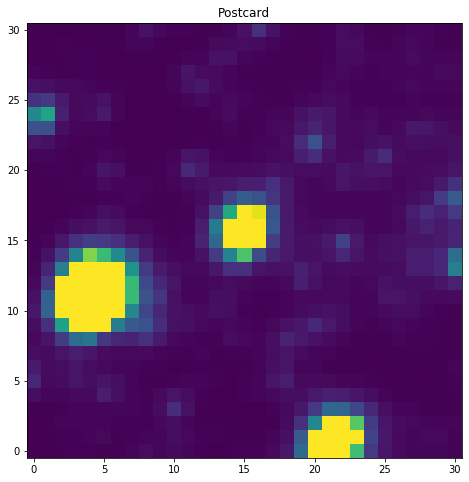

In [6]:
plt.figure(figsize=(14,8))
plt.imshow(data.post_obj.flux[0], origin='lower', vmax=400)
plt.title("Postcard")
plt.show()

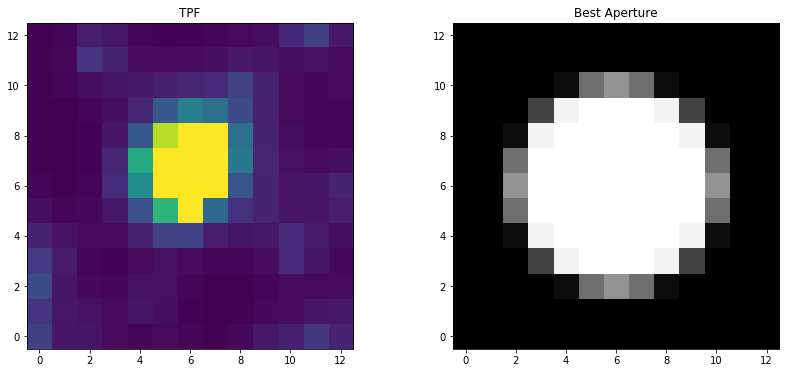

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14,6))
ax1.imshow(data.tpf[0], origin='lower', vmax=300)
ax1.set_title('TPF')
ax2.imshow(data.aperture, origin='lower', cmap='Greys_r')
ax2.set_title('Best Aperture');

At first glance, this aperture may be a little big... But we'll look at that later. First, let's see what the background looks like. There are two steps to the background subtraction: on the postcard level and on the TPF level. We can check how much background was subtracted by calling:

In [8]:
data.bkg_type

AttributeError: 'TargetData' object has no attribute 'bkg_type'

"PC_LEVEL" means Postcard Level, so no additional background was subtracted at the TPF level, which is probably for the best because this TPF is quite crowded! In the future, we will also have a $\textbf{2D_BKG}$ setting as well, where we find a interpolate on the postcard level.

In [ ]:
plt.plot(data.time, data.flux_bkg, linewidth=2)
plt.xlabel('Time (BJD-2457000)')
plt.ylabel('Background Flux');

This is pretty close to what we expect for the background, given the scattered light from Earth. We also create Quality Flags for the user. These will alert the user of spacecraft issues, such as thruster fires, where the data at that time may not be good/useful. We can see how many data points are quality flagged:

In [ ]:
plt.plot(data.time, data.quality, 'ko')
plt.title("# Bad Cadences = {}".format(
            len(np.where(data.quality !=0)[0])));

Any cadence where Quality Flag != 0 is potentially a bad one. I think it's time to plot our first light curve! We're only plotting the cadences with good quality flags. We provide $\textbf{four}$ different light curve options:
    1. Raw Flux -- Just aperture photometry.
    2. Correct Flux -- Background subtraction, removal of long term trends, using the first four CBV modes to correct for similarities across the detector.
    3. PCA Flux -- Using the SPOC provided CBVs to remove common systematics in light curves on the same CCD.
    4. PSF Flux -- The point-spread function modeled flux.

In [ ]:
q = data.quality == 0

#plt.plot(data.time[q], data.raw_flux[q]/np.median(data.raw_flux[q]) , 'k')
plt.plot(data.time[q], data.corr_flux[q]/np.median(data.corr_flux[q]) + 0.01, 'r')
plt.plot(data.time[q], data.pca_flux[q]/np.median(data.pca_flux[q]) + 0.035, 'y')
plt.plot(data.time[q], data.psf_flux[q]/np.median(data.psf_flux[q]) + 0.06, 'b')

plt.xlabel('Time (BJD-2457000)')
plt.ylabel('Normalized Flux + Constant');

Yay light curves! Yay a signal! What could it be?? First, we should try creating a light curve with a smaller aperture, to make sure there isn't a background source causing this signal. TESS's pixels are large, so this is a good test to do. LUCKILY! Every $\texttt{eleanor.TargetData()}$ object comes equipt with all of the apertures we tested and all of the raw and corrected fluxes for these additional apertures.

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3], height_ratios=[2]) 
ax0 = plt.subplot(gs[0])
ax0.imshow(data.all_apertures[13], origin='lower')
ax1 = plt.subplot(gs[1])
ax1.plot(data.time[q], data.all_corr_lc[13][q])
plt.show()

If the 21 apertures $\texttt{eleanor.TargetData()}$ provides you with isn't enough, or you want to try a different shape or weighting scheme, you can create your own 2D array of the same shape as the TPF and pass that in as an aperture.

In [ ]:
mask = np.zeros(np.shape(data.tpf[0]))
mask[5,7] = 1
mask[6:8,6:9] = 1
mask[8,7] = 1

data.get_lightcurve(aperture=mask)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3], height_ratios=[2]) 
ax0 = plt.subplot(gs[0])
ax0.imshow(mask, origin='lower')
ax1 = plt.subplot(gs[1])
ax1.plot(data.time[q], data.corr_flux[q])
plt.show()

In [ ]:
data.pca(flux=data.corr_flux, modes=7)
plt.plot(data.time[q], data.pca_flux[q]+160, 'k', label='7 CBVs')
data.pca(flux=data.corr_flux, modes=1)
plt.plot(data.time[q], data.pca_flux[q], 'r', label='1 CBV')
plt.legend(ncol=2);

To save your TPF and light curves, it's as easy as

In [ ]:
data.save()

# Pass in Coordinates $\rightarrow$ Get a Light Curve for Multiple Sectors

Great! Now we know how to create a light curve using $\texttt{eleanor.Source()}$ and $\texttt{eleanor.TargetData()}$ with a TIC ID. Now, let's do it all over again, but this time we'll highlight two additional features:

    1. Pass in coordinates to get a light curve.
    2. Create a light curve for a source observed in multiple sectors.

First, we have to assign our coordinates with a unit. This allows users to pass in coordinates in degrees or hourangle. Then, instead of calling $\texttt{eleanor.Source()}$ as we did last time, we'll call $\texttt{eleanor.multi_sectors()}$, which additionally requires a list of sectors you want. Or, if you simply want all of the available sectors, you set the input $\textbf{sectors = "all"}$. If we call $\texttt{eleanor.Source()}$, it will return the light curve for the most recent sector the target was observed in.

In [15]:
ra  = 95.91767
dec = -75.075775

stars = eleanor.multi_sectors(coords=SkyCoord(ra,dec, unit=(u.deg)), 
                              sectors="all", tc=True)

Found star in Sector(s) 1 2 3 4 5 6 7 8 9 10 11 12


KeyboardInterrupt: 

$\texttt{eleanor.multi_sectors()}$ returns a list of $\texttt{eleanor.Source()}$ objects! We can then pass these into $\texttt{eleanor.TargetData()}$ individually to create light curves for each sector.

In [ ]:
time = np.array([])
flux = np.array([])

for star in stars:
    datum = eleanor.TargetData(star, do_pca=True)
    
    q = datum.quality == 0
    
    time = np.append(time, datum.time[q])
    flux = np.append(flux, datum.corr_flux[q]/np.nanmedian(datum.corr_flux[q]))

In [ ]:
%matplotlib notebook
plt.rcParams['font.size'] = 10
plt.figure(figsize=(5,3))
plt.plot(time, flux, 'k')
plt.xlabel('Time (BJD-2457000)')
plt.ylabel('Normalized Flux')
plt.show()

# Let's do some Gyrochronology & Flare Finding!

In [ ]:
import stella

In [ ]:
ys = stella.YoungStars(time=time, flux=flux, tic=stars[0].tic)

In [ ]:
ys.savitsky_golay()

In [ ]:
ys.identify_flares()

In [ ]:
ys.flares

In [ ]:
%matplotlib notebook
ys.display_flares()

# The $\texttt{eleanor}$ team
![alt text](da_squad.jpg "Team")

# Potentially Useful Links

[eleanor Github](https://github.com/afeinstein20/eleanor) /
[stella Github](https://github.com/afeinstein20/stella)

[eleanor Documentation](https://adina.feinste.in/eleanor)

[eleanor Paper ArXiv Link](https://arxiv.org/abs/1903.09152)